<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/One_Knight_Stansd_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza.soroudi@ gmail.com


[Linkedin news letter: ](
https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/ )

In [1]:
!pip install pyomo
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.7 MB/s eta 0:00:00


{3: [11, 14],
 4: [8, 17],
 8: [4, 21],
 9: [13, 17, 20, 22],
 10: [14, 18, 21, 23],
 11: [3, 22],
 13: [9, 21],
 14: [3, 10, 22, 27],
 17: [4, 9, 21, 28],
 18: [10, 22],
 20: [9, 28],
 21: [8, 10, 13, 17],
 22: [9, 11, 14, 18],
 23: [10, 27],
 27: [14, 23],
 28: [17, 20]}

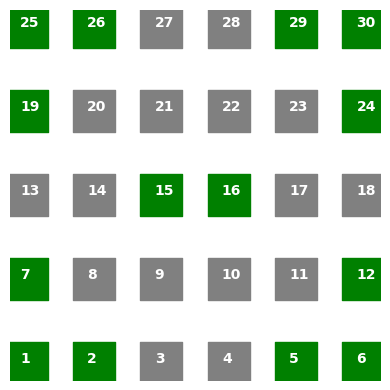

In [2]:
counter =0
dic ={}
banned = [1,2,7, 5,6,12,15,16, 19,25,26, 29,30,24]
all_nodes= [i for i in range(1,31)]
#banned =random.sample(all_nodes, 14)

plt.figure(figsize=(4,4))
for r in range(1,6):
  for c in range(1,7):
    counter+=1
    dic[counter,'x']=c
    dic[counter,'y']=r
    if counter in banned:
      KOL = 'g'
    else:
      KOL = 'grey'

    plt.scatter(c,r,s=900, marker='s', c= KOL)
    plt.text(c-0.1,r,s=str(counter), c= 'w', fontweight='bold')
plt.axis('off')
plt.tight_layout()



nodes = [n for n in range(1,1+counter)]
change = [(1,2),(1,-2),(-1,2),(-1,-2)]
change += [ (ch[1],ch[0]) for ch in change]

allowed ={}

for n in nodes:
  if n not in banned:

    x0,y0 = dic[n,'x'], dic[n,'y']
    allowed[n] = [m for m in nodes if m not in banned and (dic[m,'x']-dic[n,'x'], dic[m,'y']-dic[n,'y']) in change]


allowed

In [3]:
start_node = 13
if start_node in banned:
  a = [n for n in all_nodes if n not in banned]
  start_node = random.sample(a,1)
  start_node =start_node[0]

In [4]:
eligible_nodes = [n for n in allowed.keys()]

model = AbstractModel()
model.i = Set(initialize = eligible_nodes)
model.j = Set(initialize=model.i)

model.flow = Var(model.i,model.j, bounds=(0,1), within=Reals)
model.U = Var(model.i,model.j, within=Binary)
model.include = Var(model.i, within=Binary)

model.source = Var(model.i, within=NonNegativeReals)

def rule_C1(model,i):
  return model.source[i]- model.include[i]/100 ==  sum(model.flow[i,j]-model.flow[j,i] for j in model.j if j in allowed[i] )
model.C1=Constraint(model.i, rule=rule_C1)

def rule_C2(model,i,j):
  if i!=j:
    return model.flow[i,j] <= model.U[i,j]
  else:
    return model.flow[i,j] == 0
model.C2=Constraint(model.i, model.j, rule=rule_C2)

def rule_C3(model,i):
  return sum(model.U[i,j] for j in model.j if j in allowed[i] )<= 1
model.C3=Constraint(model.i, rule=rule_C3)

def rule_C4(model,i):
  if i != start_node:
    return sum(model.U[j,i] for j in model.j if i in allowed[j] )<= 1
  else:
    return sum(model.U[j,i] for j in model.j if i in allowed[j] )== 0
model.C4=Constraint(model.i, rule=rule_C4)


def rule_OF(model):
    return  sum(model.include[i] for i in model.i )
model.obj1 = Objective(rule=rule_OF, sense=maximize)

In [5]:
!apt-get install -y -qq coinor-cbc

Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:

In [6]:
opt = SolverFactory('cbc', executable='/usr/bin/cbc')
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"

instance = model.create_instance()

for i in instance.i:
  if i!=start_node:
    instance.source[i].fix(0)

In [7]:
results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal and nothing more")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print('OF= ', value(instance.obj1) )

this is feasible and optimal and nothing more
OF=  16.0


3 14 0
4 17 1
8 4 2
9 22 3
10 18 4
11 3 5
13 21 6
14 27 7
17 28 8
20 9 9
21 8 10
22 11 11
23 10 12
27 23 13
28 20 14


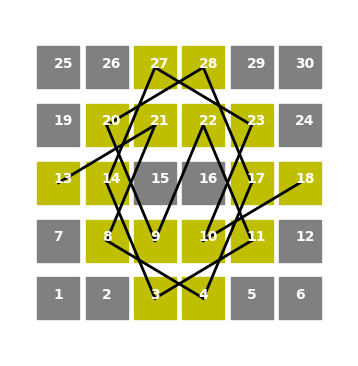

In [9]:
plt.figure(figsize=(4,4))
for counter in nodes:
  if counter not in banned:
    KOLOR = 'y'
  else:
    KOLOR = 'grey'
  x = dic[counter,'x']
  y = dic[counter,'y']
  plt.scatter(x,y,s=900, marker='s', c= KOLOR)
  plt.text(x-0.1,y,s=str(counter), c= 'w', fontweight='bold')
plt.tight_layout()
plt.xlim(0,7)
plt.ylim(0,6)
plt.axis('off')
continue_move = True
fnode = start_node
counter = 0
for i in instance.i:
  for j in instance.j:
    if i!=j and value(instance.flow[i,j])>0 :
      x0,y0 = dic[i,'x'],dic[i,'y']
      x1,y1 = dic[j,'x'],dic[j,'y']
      plt.plot([x0,x1],[y0,y1], c='k', lw=2)
      counter +=1
